# Loading required libraries

In [1]:
 pip install --upgrade category_encoders

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np                                # importing numpy numerical calculation
import pandas as pd                                 # importing pandas dataframe manipulation
import warnings                                     # removing the warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import category_encoders
from category_encoders import BinaryEncoder
import pickle
from sklearn.metrics import accuracy_score

# Uploading Dataset

In [3]:
# uploaded = files.upload()

# Reading the CSV data file using pandas

In [4]:
df = pd.read_csv('LoanExport.csv')

In [5]:
df.rename(columns = {'CreditScore':'CibilScore'},inplace = True)

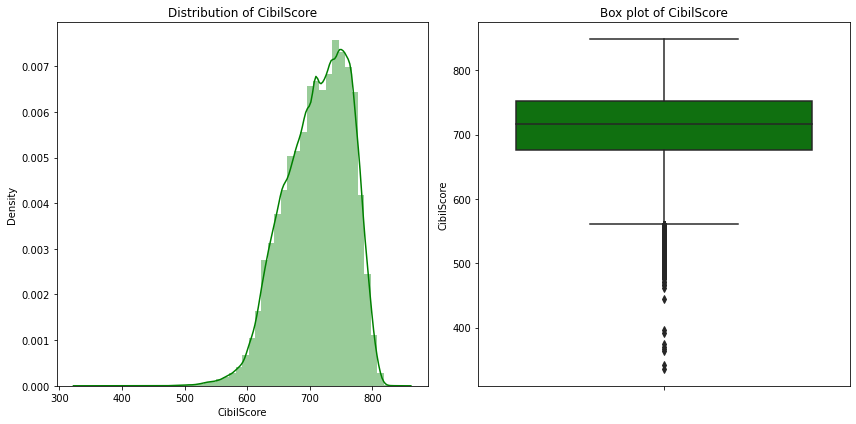

(291451, 28)


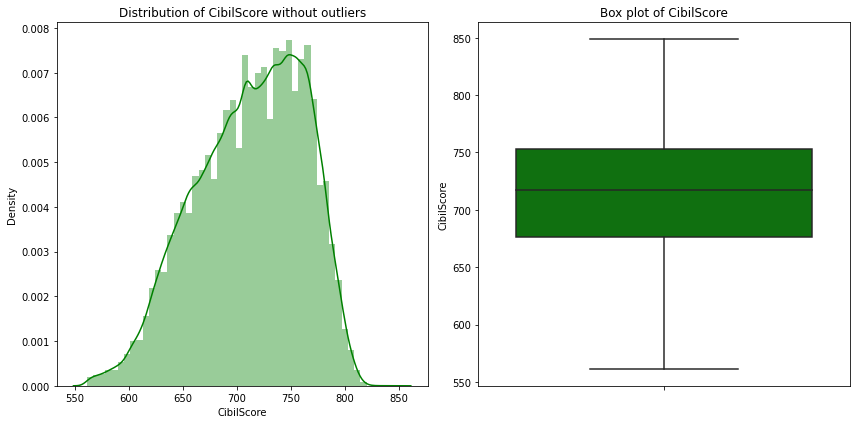

(290234, 28)




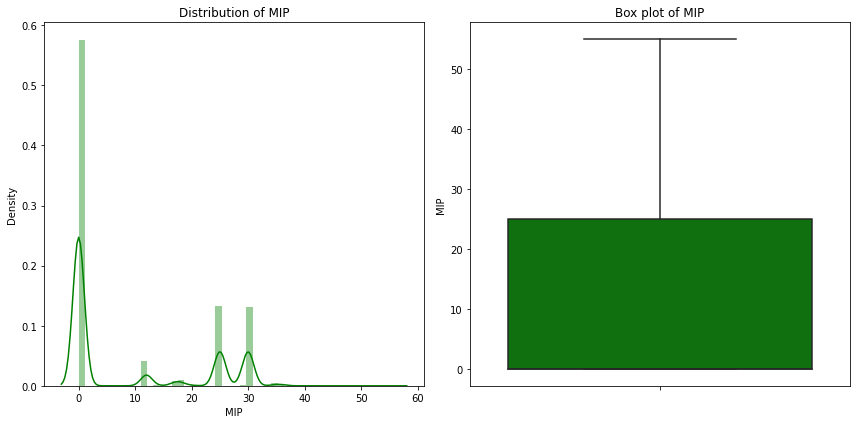

(290234, 28)




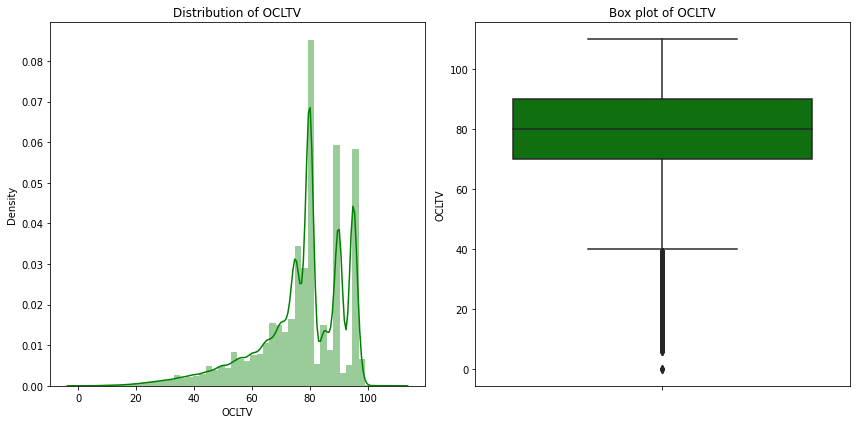

(290234, 28)


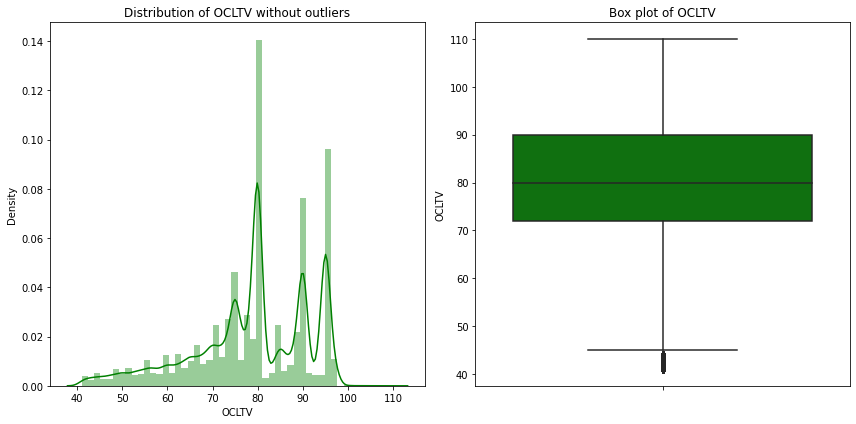

(280480, 28)




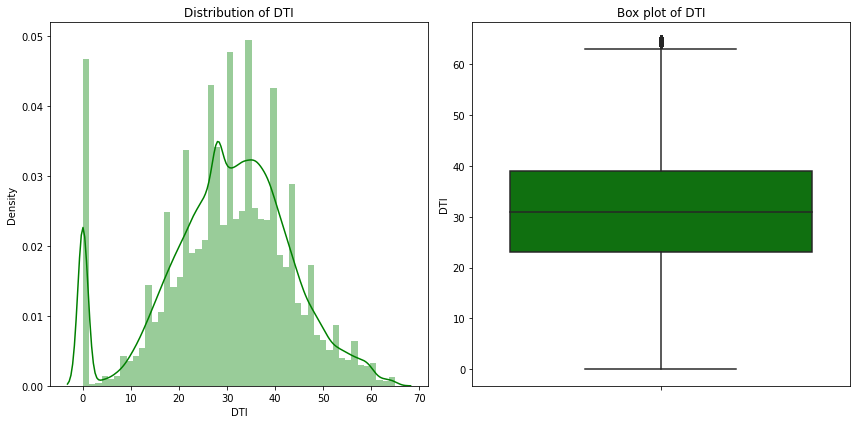

(280480, 28)


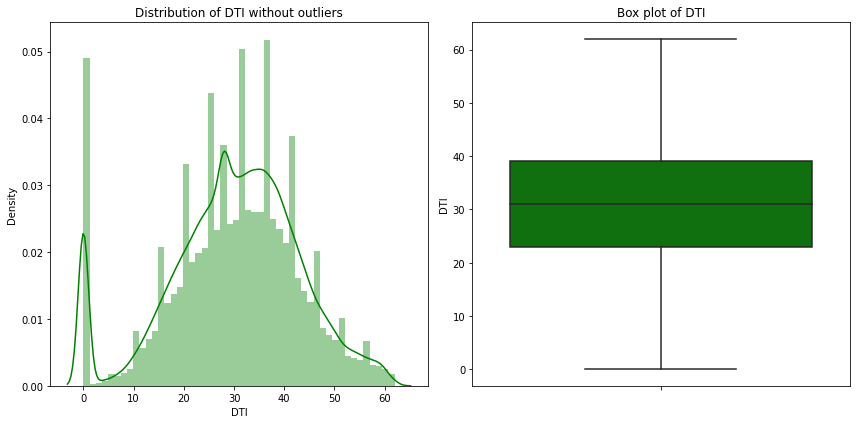

(279759, 28)




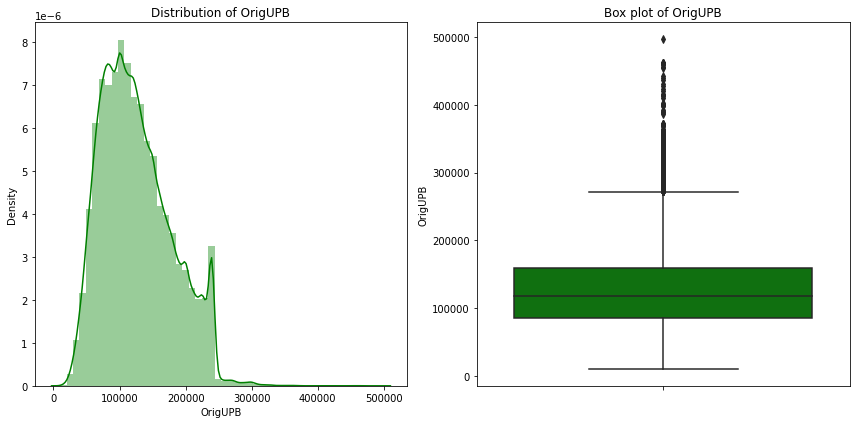

(279759, 28)


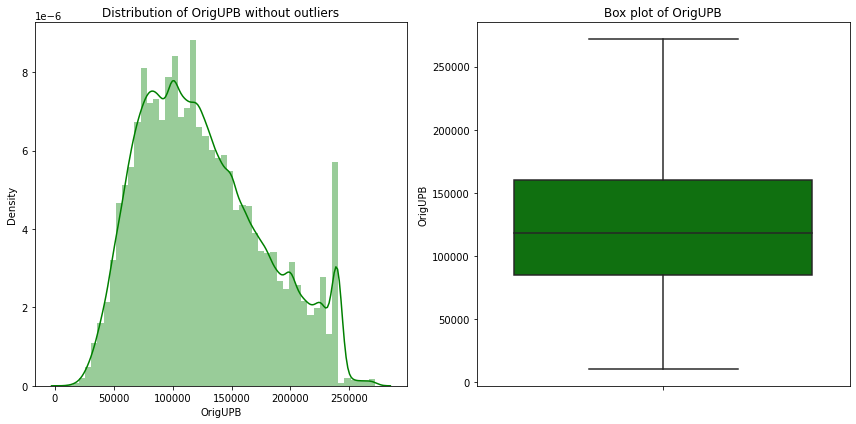

(278709, 28)




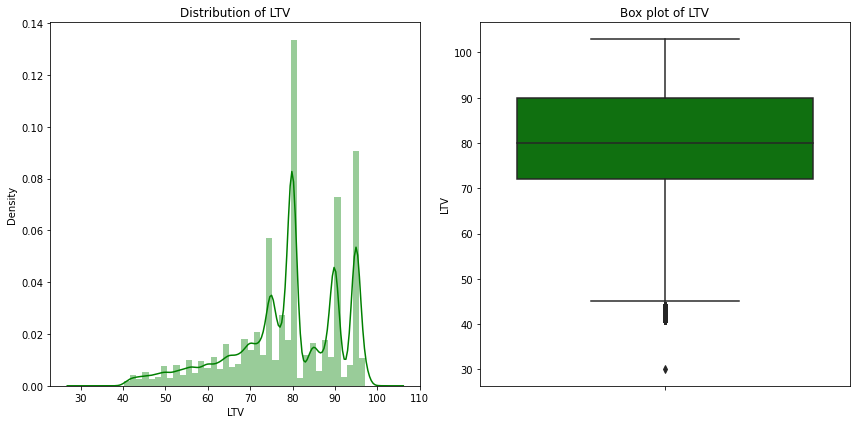

(278709, 28)


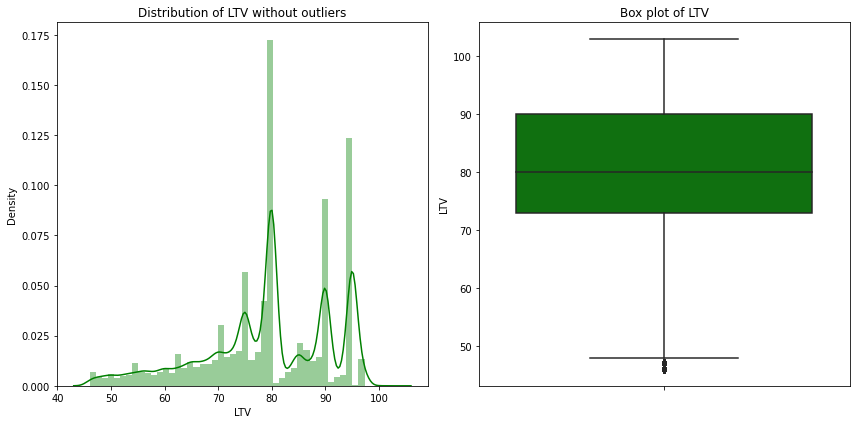

(274155, 28)




In [6]:
def check_outliers(x):
  global df
  fig, axes = plt.subplots(1,2,figsize=(12,6))
  sns.distplot(df[x],color='g',ax=axes[0])
  sns.boxplot(y=df[x],color='g',ax=axes[1])
  axes[0].set_title('Distribution of ' + x)
  axes[1].set_title('Box plot of '+ x)
  plt.tight_layout()
  plt.show()
  print(df.shape)
def remove_outliers(x):
  global df
  Q1= df[x].quantile(0.25)
  Q3 = df[x].quantile(0.75)
  IQR = Q3 - Q1
  upper_limit = Q3 + 1.5 * IQR
  lower_limit = Q1 - 1.5 * IQR
  df=df[(df[x] > lower_limit) & (df[x] < upper_limit)]
  fig, axes = plt.subplots(1,2,figsize=(12,6))
  sns.distplot(df[x],color='g',ax=axes[0])
  sns.boxplot(y=df[x],color='g',ax=axes[1])
  axes[0].set_title('Distribution of '+ x + ' without outliers')
  axes[1].set_title('Box plot of '+ x)
  plt.tight_layout()
  plt.show()
  print(df.shape)
df['CibilScore'].replace(to_replace = 0, value = df['CibilScore'].mean(), inplace=True)
df['Units'].replace(to_replace = 0, value = 1, inplace=True)
for i in ['CibilScore','MIP','OCLTV','DTI','OrigUPB','LTV']:
  check_outliers(i)
  if i != 'MIP':
    remove_outliers(i)
  print('')
  print("")
df['FirstPaymentDate'] = pd.to_datetime(df['FirstPaymentDate'], format='%d%y%m')
df['MaturityDate'] = pd.to_datetime(df['MaturityDate'], format='%d%y%m')
df.replace({'FirstTimeHomebuyer': {'X':'N'}}, inplace=True)
df.replace({'PPM': {'X':'N'}}, inplace=True)
mode_of_SellerName = df.pivot_table(values='SellerName', columns='ServicerName', aggfunc=(lambda x: x.mode()[0]))
miss_values = df['SellerName'].isnull()
df.loc[miss_values, 'SellerName'] = df.loc[miss_values,'ServicerName'].apply(lambda x: mode_of_SellerName[x])
df = df.drop(['ProductType'], axis=1)
df = df.drop(['LoanSeqNum'], axis=1)
df = df.drop(['LTV'], axis=1)
df = df.drop(['PostalCode'], axis=1)
new_df=df


In [7]:
df.duplicated().sum() # checking for duplicates

40

In [8]:
df.drop_duplicates(keep = 'first').shape # removing duplicates

(274115, 24)

In [9]:
categorical_columns = ['FirstTimeHomebuyer','MSA','Occupancy','Channel','PPM','PropertyState','PropertyType','LoanPurpose','NumBorrowers','SellerName','ServicerName']

In [10]:
df.describe()

,CibilScore,MIP,Units,OCLTV,DTI,OrigUPB,OrigInterestRate,OrigLoanTerm,EverDelinquent,MonthsDelinquent,MonthsInRepayment
count,274155.000000,274155.000000,274155.000000,274155.000000,274155.000000,274155.000000,274155.000000,274155.000000,274155.000000,274155.000000,274155.000000
mean,710.984808,9.713348,1.024016,79.139093,30.132009,125791.931572,6.928058,359.844719,0.199643,1.870347,60.417158
std,49.747656,12.799575,0.192621,12.083207,12.995764,52021.946610,0.343737,2.204612,0.399732,8.896728,45.737455
min,561.000000,0.000000,1.000000,46.000000,0.000000,10000.000000,4.000000,301.000000,0.000000,0.000000,1.000000
25%,675.000000,0.000000,1.000000,73.000000,23.000000,85000.000000,6.750000,360.000000,0.000000,0.000000,34.000000
50%,716.000000,0.000000,1.000000,80.000000,31.000000,119000.000000,6.875000,360.000000,0.000000,0.000000,48.000000
75%,751.000000,25.000000,1.000000,90.000000,39.000000,160000.000000,7.125000,360.000000,0.000000,0.000000,63.000000
max,849.000000,55.000000,4.000000,110.000000,62.000000,272000.000000,12.350000,361.000000,1.000000,180.000000,212.000000


In [11]:
#Binary encoding
encoder = BinaryEncoder(cols =categorical_columns)
newdata = encoder.fit_transform(df[categorical_columns])
df = pd.concat([df, newdata], axis = 1)
df = df.drop(categorical_columns, axis = 1)

In [12]:
# Dividing dataset into two parts for training and testing
part_80 = df.sample(frac = 0.8) #train dataset
part_20 = df.drop(part_80.index) # test dataset

In [13]:
X = part_80.drop(['FirstPaymentDate','MaturityDate','EverDelinquent'],axis=1)

In [14]:
Y = part_80[['EverDelinquent']]

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=3)

In [16]:
print("Training data : ", X_train.shape)
print("Testing data : ", X_test.shape)

Training data :  (175459, 51)
Testing data :  (43865, 51)


In [17]:
# Scaling the data
Rscaler = RobustScaler()
X_train = Rscaler.fit_transform(X_train)
X_test = Rscaler.fit_transform(X_test)

In [18]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [19]:
rf=RandomForestClassifier(max_depth = 10, n_estimators=100, random_state = 5)
rf.fit(X_train, Y_train)

RandomForestClassifier(max_depth=10, random_state=5)

In [20]:
rf_accuracy = round(rf.score(X_train,Y_train)*100)
print("Accuaracy for Random Forest: ",rf_accuracy)
rf_accuracy = 100*rf.score(X_test,Y_test)
rf_accuracy

Accuaracy for Random Forest:  100


100.0

In [21]:
lsvc = LinearSVC(dual=False)
lsvc

LinearSVC(dual=False)

In [22]:
lsvc.fit(X_train,Y_train)
score = 100*lsvc.score(X_train,Y_train)
score

100.0

In [23]:
score = 100*lsvc.score(X_test,Y_test)
score

100.0

In [24]:
# # Saving lsvc model to a file using python pickle
# with open('lsvc_pickle','wb') as file:
#     pickle.dump(lsvc,file)

In [25]:
# # Loading saved model
# with open('lsvc_pickle','rb') as file:
#     lsvcp = pickle.load(file)

In [26]:
# Y_data = part_20.drop(['FirstPaymentDate','MaturityDate','EverDelinquent'],axis=1)

In [27]:
# Y_data = Rscaler.fit_transform(Y_data)
# Y_data = pd.DataFrame(Y_data)

In [28]:
# Y_true = part_20['EverDelinquent']

In [29]:
# lsvc_pred=lsvcp.predict(Y_data)

In [30]:
# 100*accuracy_score(Y_true,lsvc_pred) # prediction accuracy for test data using lsvc

In [31]:
# # Saving random forest model to a file using python pickle
# with open('rf_pickle','wb') as file:
#     pickle.dump(rf,file)

In [32]:
# with open('rf_pickle','rb') as file:
#     rfp = pickle.load(file)

In [33]:
# rf_pred = rfp.predict(Y_data)

In [34]:
# 100*accuracy_score(Y_true,rf_pred) # prediction accuracy for test data using rf

In [35]:
Xn=new_df.drop(['FirstPaymentDate','EverDelinquent', 'MaturityDate'], axis=1)

In [36]:
Yn=new_df['EverDelinquent']
Yn=Yn.values

In [37]:
Xn.head(5)

,CibilScore,FirstTimeHomebuyer,MSA,MIP,Units,Occupancy,OCLTV,DTI,OrigUPB,OrigInterestRate,...,PPM,PropertyState,PropertyType,LoanPurpose,OrigLoanTerm,NumBorrowers,SellerName,ServicerName,MonthsDelinquent,MonthsInRepayment
0,708.936991,N,16974,25,1,O,89,27,117000,6.750,...,N,IL,SF,P,360,2,FL,WASHINGTONMUTUALBANK,0,52
1,708.936991,N,19740,0,1,O,73,17,109000,6.500,...,N,CO,SF,N,360,1,FT,CHASEHOMEFINANCELLC,0,144
2,708.936991,N,29940,0,1,O,75,16,88000,6.875,...,N,KS,SF,N,360,2,FL,WASHINGTONMUTUALBANK,0,67
3,708.936991,N,31084,0,1,O,76,14,160000,6.875,...,N,CA,SF,N,360,2,GM,GMACMTGECORP,0,35
4,708.936991,N,35644,0,1,O,78,18,109000,7.125,...,N,NJ,SF,N,360,2,GM,GMACMTGECORP,0,54


In [38]:
from sklearn.compose import make_column_transformer
import category_encoders as ce
col_tra = make_column_transformer((RobustScaler(), ['CibilScore', 'MIP', 'Units','OCLTV','DTI','OrigUPB','OrigInterestRate','OrigLoanTerm','MonthsDelinquent','MonthsInRepayment']),
    (ce.BinaryEncoder(),['FirstTimeHomebuyer','MSA','Occupancy','Channel','PPM','PropertyState','PropertyType','LoanPurpose','NumBorrowers','SellerName','ServicerName']))

In [39]:
col_tra.fit_transform(Xn)

array([[-0.09293433,  1.        ,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [-0.09293433,  0.        ,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [-0.09293433,  0.        ,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.63157895,  0.        ,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       [ 1.69736842,  0.        ,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       [ 1.75      ,  0.        ,  0.        , ...,  1.        ,
         0.        ,  0.        ]])

In [40]:
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

In [41]:
pipe=make_pipeline(col_tra,rf)


In [42]:
pipe.predict(Xn)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [43]:
import pickle
 
with open('pipe_rf.pkl', 'wb') as files:
    pickle.dump(pipe, files)

In [44]:
with open('pipe_rf.pkl', 'rb') as files:
    loaded_model = pickle.load(files)

In [45]:
t_1=Xn[:5].to_numpy()

In [46]:
t_2=pd.DataFrame(t_1)

In [47]:
t_2.rename(columns = {0:'CibilScore', 
                   1:'FirstTimeHomebuyer',
                  2:'MSA', 
                   3:'MIP',
                  4:'Units', 
                   5:'Occupancy',
                  6:'OCLTV', 
                  7:'DTI',
                  8:'OrigUPB',
                   9:'OrigInterestRate',
                   10:'Channel',              
                   11:'PPM',
                   12:'PropertyState',
                   13:'PropertyType',
                   14:'LoanPurpose',
                   15:'OrigLoanTerm',
                   16:'NumBorrowers',
                    17:'SellerName',
                   18:'ServicerName',
                   19:'MonthsDelinquent',
                   20:'MonthsInRepayment',

                             }, 
        inplace = True)

In [48]:
t_2

,CibilScore,FirstTimeHomebuyer,MSA,MIP,Units,Occupancy,OCLTV,DTI,OrigUPB,OrigInterestRate,...,PPM,PropertyState,PropertyType,LoanPurpose,OrigLoanTerm,NumBorrowers,SellerName,ServicerName,MonthsDelinquent,MonthsInRepayment
0,708.936991,N,16974,25,1,O,89,27,117000,6.75,...,N,IL,SF,P,360,2,FL,WASHINGTONMUTUALBANK,0,52
1,708.936991,N,19740,0,1,O,73,17,109000,6.5,...,N,CO,SF,N,360,1,FT,CHASEHOMEFINANCELLC,0,144
2,708.936991,N,29940,0,1,O,75,16,88000,6.875,...,N,KS,SF,N,360,2,FL,WASHINGTONMUTUALBANK,0,67
3,708.936991,N,31084,0,1,O,76,14,160000,6.875,...,N,CA,SF,N,360,2,GM,GMACMTGECORP,0,35
4,708.936991,N,35644,0,1,O,78,18,109000,7.125,...,N,NJ,SF,N,360,2,GM,GMACMTGECORP,0,54


In [49]:
loaded_model.predict(t_2)

array([0, 0, 0, 0, 0], dtype=int64)

In [50]:
pred=loaded_model.predict(Xn)